In [178]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dataset: FoodAPS National Household Food Acquisition and Purchase Survey

This dataset contains the results of the USDA's National Household Food Acquisition and Purchase Survey (FoodAPS). It
collects information about "foods purchased or otherwise acquired for consumption at home and away from home, including
foods acquired through food and nutrition assistance programs."


In [179]:
hh_df = pd.read_csv("data/faps_household_puf.csv")

fah_df = pd.read_csv("data/faps_fahnutrients.csv")
fafh_df = pd.read_csv("data/faps_fafhnutrient_puf.csv")

In [180]:
hh_df = hh_df[(hh_df["numguests"] == 0) & (hh_df["hhsizechange"] == 0)]

In [181]:
import enum


class SNAPNowAdmin(enum.Enum):
    NO_MATCH = 0
    CONFIRMED_SNAP = 1
    CONFIRMED_NON_SNAP = 2
    VALID_SKIP = -996


hh_df = hh_df[hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value]

In [182]:
hh_nums = hh_df["hhnum"]

snap_fah_df = fah_df[fah_df["hhnum"].isin(hh_nums)]
snap_fafh_df = fafh_df[fafh_df["hhnum"].isin(hh_nums)]

In [183]:
REQUIRED_VARIABLES = ["totsug", "satfat", "monofat"]

snap_fah_df = snap_fah_df[REQUIRED_VARIABLES]
snap_fafh_df = snap_fafh_df[REQUIRED_VARIABLES]

In [184]:
snap_fah_df = snap_fah_df.dropna(how="all")
snap_fafh_df = snap_fafh_df.dropna(how="all")

In [185]:
snap_fah_df = snap_fah_df.fillna(0, inplace=True)
snap_fafh_df = snap_fafh_df.fillna(0, inplace=True)

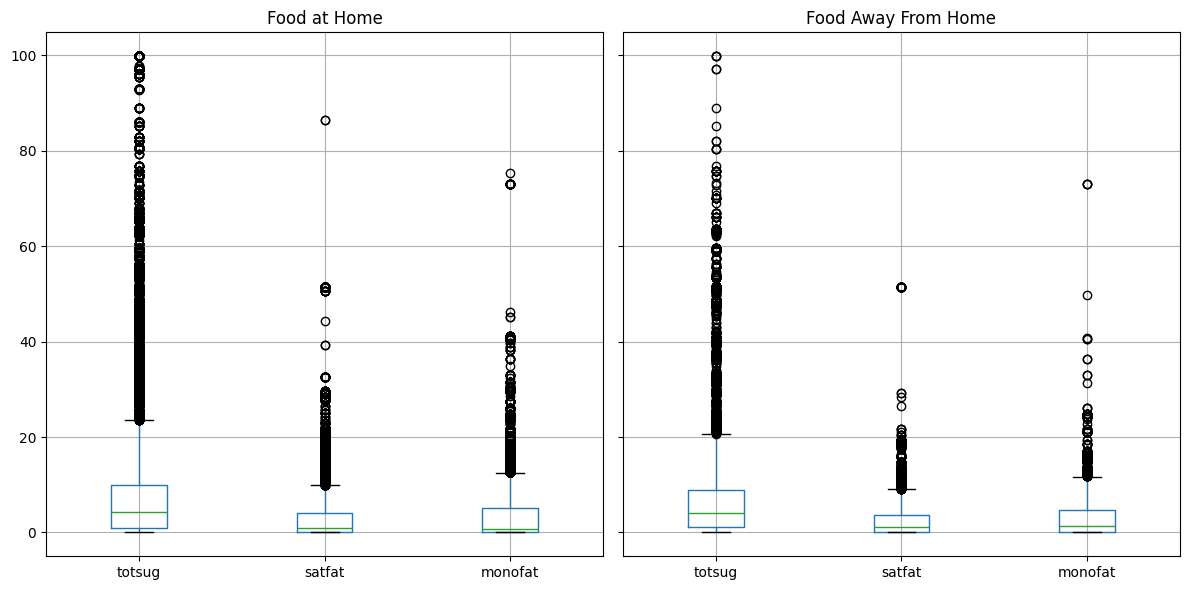

In [186]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

snap_fah_df.boxplot(ax=ax1)
ax1.set_title("Food at Home")

snap_fafh_df.boxplot(ax=ax2)
ax2.set_title("Food Away From Home")

plt.tight_layout()
plt.show()

In [187]:
snap_fah_df = snap_fah_df.apply(np.log)
snap_fafh_df = snap_fafh_df.apply(np.log)

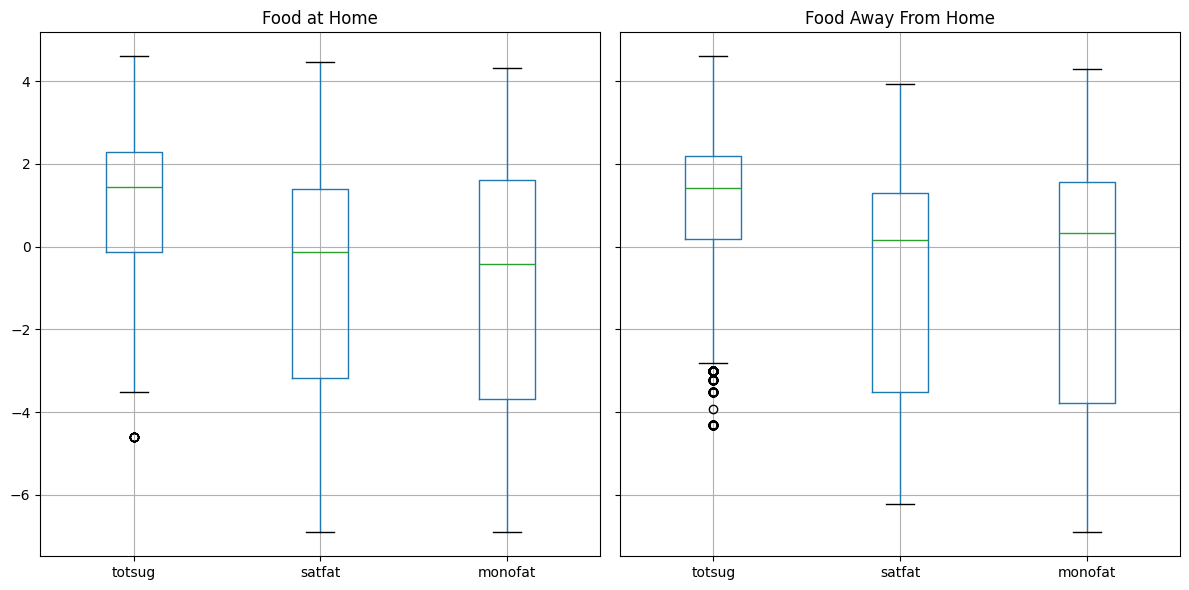

In [188]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

snap_fah_df.boxplot(ax=ax1)
ax1.set_title("Food at Home")

snap_fafh_df.boxplot(ax=ax2)
ax2.set_title("Food Away From Home")

plt.tight_layout()
plt.show()